In [216]:
import numpy as np
import matplotlib.pyplot as plt

In [217]:
def calc_barys_coef(x):
    w = np.zeros(len(x))
    for i in range(len(x)):
        w[i] = 1/np.prod(x[i] - np.delete(x,i))
    return w

def eval_barys_coefs(x, x_data, y_data):
    p_top = 0
    p_bottom = 0
    w = calc_barys_coef(x_data)
    
    for i in range(len(x_data)):
        if x != x_data[i]:
            W = w[i]/(x - x_data[i])
            p_top += W*y_data[i]
            p_bottom += W
        else:
            return y_data[i]
    return p_top/p_bottom

def lagrange_bary_interp(x, x_data, y_data):
    return np.array([eval_barys_coefs(x[i],x_data,y_data) for i in range(len(x))])

def create_interp_n_bary(a,b,n,f):
    x_data = np.linspace(a,b,n)
    y_data = f(x_data)

    x_test = np.linspace(a,b,1001)
    y_test = lagrange_bary_interp(x_test, x_data, y_data)

    return (x_test, y_test)



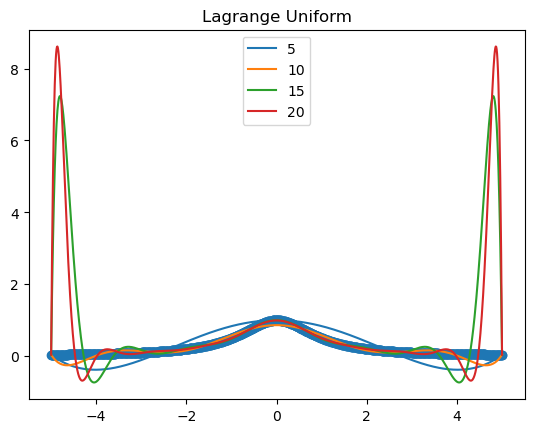

In [218]:
def f_prob1(x):
    return 1/(1+x**2)

def df_prob1(x):
    return -2*x/(1+x**2)**2


def driver_prob1():

    x_test = np.linspace(-5,5,1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test,y_real)

    ns = [5 , 10, 15, 20]
    
    for n in ns:
        (x_interp, y_interp) = create_interp_n_bary(-5,5,n,f_prob1)
        plt.plot(x_interp, y_interp, label = str(n))
    plt.title("Lagrange Uniform")
    plt.legend()
    plt.show()
driver_prob1()   

In [239]:
def create_hmat(x_data):
    n = len(x_data)
    H = np.zeros([2*n,2*n])
    print(n)

    for i in range(n):
        for j in range(2*n):
            H[i][j] = x_data[i]**j

    for i in range(n):
        H[i+n][0] = 0
        for j in range(1,2*n):
            H[i+n][j] = j*x_data[i]**(j-1)
    return H

def create_coefs(x_data, y_data, z_data):
    H = create_hmat(x_data)
    # print(H)
    Y = np.hstack((y_data,z_data))
    # print(Y)
    coefs = np.linalg.solve(H,Y)

    return coefs

def eval_interp_H(x, coefs):
    return np.sum(x**i*coefs[i] for i in range(len(coefs)))

def eval_interpnd_H(x_arr,coefs):
    return [eval_interp_H(x, coefs) for x in x_arr]

def create_interp_H(a,b,n,f,df):
    x_data = np.linspace(a,b,n)
    y_data = f(x_data)
    z_data = df(x_data)

    coefs = create_coefs(x_data,y_data,z_data)
    

    x_test = np.linspace(a,b,1001)
    y_test = eval_interpnd_H(x_test, coefs)

    return (x_test, y_test)
    
def create_hot_moms(ugly_mom): #hey guy take a look at this
    ugly_mom.milf_update = True
    hot_mom = ugly_mom
    return hot_mom

5
10


/tmp/ipykernel_107474/760613301.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(x**i*coefs[i] for i in range(len(coefs)))


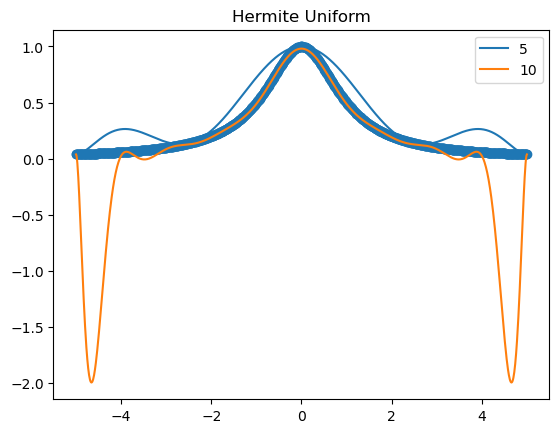

In [240]:
def driver_prob_H():

    x_test = np.linspace(-5,5,1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test,y_real)

    ns = [5,10]
    
    for n in ns:
        (x_interp, y_interp) = create_interp_H(-5,5,n,f_prob1, df_prob1)
        plt.plot(x_interp, y_interp, label = str(n))
    plt.title("Hermite Uniform")
    plt.legend()
    plt.show()
driver_prob_H()

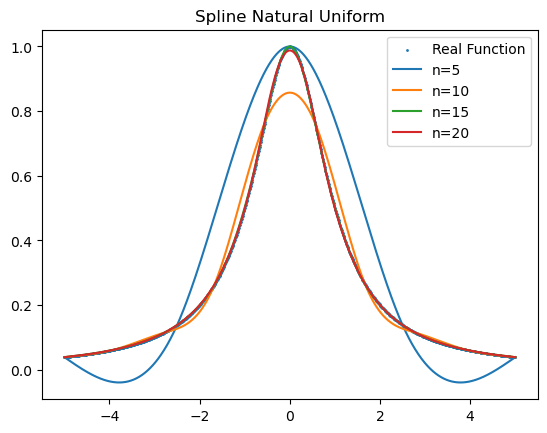

In [247]:
def create_spline_mat(n):
    S = np.zeros([n-2, n-2])

    S[0, 0] = 4
    S[0, 1] = 1
    for i in range(1, n-3):
        S[i, i-1] = 1
        S[i, i] = 4
        S[i, i+1] = 1

    S[n-3, n-4] = 1
    S[n-3, n-3] = 4

    S /= 12  # Element-wise division
    return S

def create_coefs_spline(x_data, y_data):
    n = len(x_data)
    S = create_spline_mat(n)
    Y = np.zeros(n-2)

    for i in range(n-2):
        f_i1_i2 = (y_data[i+2] - y_data[i+1]) / (x_data[i+2] - x_data[i+1])
        f_i_i1 = (y_data[i+1] - y_data[i]) / (x_data[i+1] - x_data[i])
        
        f_i_i1_i2 = (f_i1_i2 - f_i_i1) / (x_data[i+2] - x_data[i])
        
        Y[i] = f_i_i1_i2

    coefs = np.linalg.solve(S, Y)  # `S` was incorrectly referenced as `H` before
    coefs_return = np.zeros(len(coefs)+2)
    coefs_return[1:len(coefs)+1] = coefs
    return coefs_return

def eval_interp_S_nat(x, coefs, x_data, y_data):
    if x < np.min(x_data) or x > np.max(x_data):
        print("x is not between the points")
        return 0

    for i in range(1, len(x_data)):
        if x_data[i-1] <= x <= x_data[i]:
            break

    h = x_data[i] - x_data[i-1]

    bi = y_data[i-1] - coefs[i-1] * h**2 / 6
    ci = y_data[i] - coefs[i] * h**2 / 6

    f = (1/h) * (
        (1/6 * coefs[i-1] * (x_data[i] - x)**3) +
        (1/6 * coefs[i] * (x - x_data[i-1])**3) +
        bi * (x_data[i] - x) +
        ci * (x - x_data[i-1])
    )
    return f

def eval_interpnd_S_nat(x_arr, coefs, x_data, y_data):
    return [eval_interp(x, coefs, x_data, y_data) for x in x_arr]

def create_interp_spline(a, b, n, f):
    x_data = np.linspace(a, b, n)
    y_data = f(x_data)

    coefs = create_coefs_spline(x_data, y_data)
    
    x_test = np.linspace(a, b, 1001)
    y_test = eval_interpnd_S_nat(x_test, coefs, x_data, y_data)

    return x_test, y_test

def driver_prob1_S():

    x_test = np.linspace(-5, 5, 1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test, y_real, s=1, label="Real Function")

    ns = [5, 10,15,20]
    for n in ns:
        x_interp, y_interp = create_interp_spline(-5, 5, n, f_prob1)
        plt.plot(x_interp, y_interp, label=f"n={n}")
    plt.title("Spline Natural Uniform")
    plt.legend()
    plt.show()

driver_prob1_S()





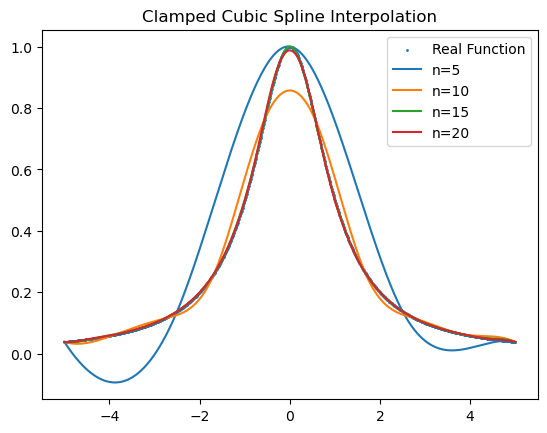

In [222]:
import numpy as np
import matplotlib.pyplot as plt

def create_spline_mat_clamped(n):
    """Creates the matrix for the clamped cubic spline system."""
    S = np.zeros((n, n))

    # Clamped boundary conditions
    S[0, 0] = 1
    S[n-1, n-1] = 1

    # Fill the main system
    for i in range(1, n-1):
        S[i, i-1] = 1
        S[i, i] = 4
        S[i, i+1] = 1

    S /= 12  # Normalize

    return S

def create_coefs_spline(x_data, y_data, alpha, beta):
    """Computes the cubic spline coefficients given the clamped boundary conditions."""
    n = len(x_data)
    S = create_spline_mat_clamped(n)
    Y = np.zeros(n)

    # Set boundary conditions (first and last derivatives)
    Y[0] = alpha
    Y[n-1] = beta

    # Compute second derivatives at internal points
    for i in range(1, n-1):
        f_i_i1 = (y_data[i+1] - y_data[i]) / (x_data[i+1] - x_data[i])
        f_i1_i2 = (y_data[i+1] - y_data[i-1]) / (x_data[i+1] - x_data[i-1])
        
        Y[i] = 2 * (f_i_i1 - f_i1_i2) / (x_data[i+1] - x_data[i-1])

    coefs = np.linalg.solve(S, Y)  
    return coefs

def eval_interp(x, coefs, x_data, y_data):
    """Evaluates the spline interpolation at a given x."""
    if x < np.min(x_data) or x > np.max(x_data):
        print("x is not between the points")
        return 0

    # Find the interval
    for i in range(1, len(x_data)):
        if x_data[i-1] <= x <= x_data[i]:
            break

    h = x_data[i] - x_data[i-1]

    # Compute Bi and Ci
    bi = y_data[i-1] - coefs[i-1] * h**2 / 6
    ci = y_data[i] - coefs[i] * h**2 / 6

    # Cubic spline interpolation formula
    f = (1/h) * (
        (1/6 * coefs[i-1] * (x_data[i] - x)**3) +
        (1/6 * coefs[i] * (x - x_data[i-1])**3) +
        bi * (x_data[i] - x) +
        ci * (x - x_data[i-1])
    )
    return f

def eval_interpnd(x_arr, coefs, x_data, y_data):
    """Evaluates the spline at multiple x values."""
    return [eval_interp(x, coefs, x_data, y_data) for x in x_arr]

def create_interp_spline_clamped(a, b, n, f, df):
    """Creates and evaluates a clamped cubic spline interpolator."""
    x_data = np.linspace(a, b, n)
    y_data = f(x_data)

    coefs = create_coefs_spline(x_data, y_data, df(x_data[0]), df(x_data[-1]))
    
    x_test = np.linspace(a, b, 1001)
    y_test = eval_interpnd(x_test, coefs, x_data, y_data)

    return x_test, y_test

def driver_prob1_S_clamped():
    """Runs and plots the clamped cubic spline interpolation."""
    x_test = np.linspace(-5, 5, 1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test, y_real, s=1, label="Real Function")

    ns = [5, 10, 15, 20]
    for n in ns:
        x_interp, y_interp = create_interp_spline_clamped(-5, 5, n, f_prob1, df_prob1)
        plt.plot(x_interp, y_interp, label=f"n={n}")

    plt.title("Clamped Cubic Spline Interpolation")
    plt.legend()
    plt.show()

driver_prob1_S_clamped()


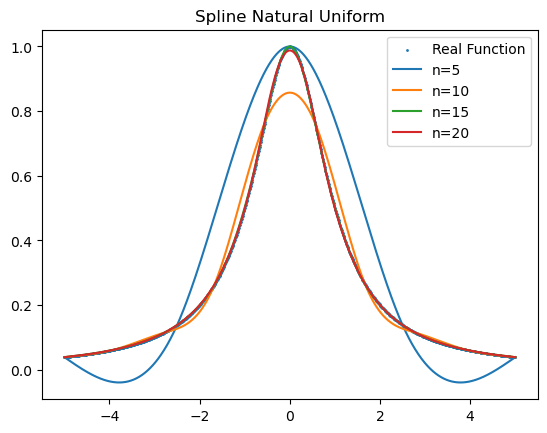

In [242]:
def create_spline_mat(n):
    S = np.zeros([n-2, n-2])

    S[0, 0] = 4
    S[0, 1] = 1
    for i in range(1, n-3):
        S[i, i-1] = 1
        S[i, i] = 4
        S[i, i+1] = 1

    S[n-3, n-4] = 1
    S[n-3, n-3] = 4

    S /= 12  # Element-wise division
    return S

def create_coefs_spline(x_data, y_data):
    n = len(x_data)
    S = create_spline_mat(n)
    Y = np.zeros(n-2)

    for i in range(n-2):
        f_i1_i2 = (y_data[i+2] - y_data[i+1]) / (x_data[i+2] - x_data[i+1])
        f_i_i1 = (y_data[i+1] - y_data[i]) / (x_data[i+1] - x_data[i])
        
        f_i_i1_i2 = (f_i1_i2 - f_i_i1) / (x_data[i+2] - x_data[i])
        
        Y[i] = f_i_i1_i2

    coefs = np.linalg.solve(S, Y)  # `S` was incorrectly referenced as `H` before
    coefs_return = np.zeros(len(coefs)+2)
    coefs_return[1:len(coefs)+1] = coefs
    return coefs_return

def eval_interp_S_nat(x, coefs, x_data, y_data):
    if x < np.min(x_data) or x > np.max(x_data):
        print("x is not between the points")
        return 0

    for i in range(1, len(x_data)):
        if x_data[i-1] <= x <= x_data[i]:
            break

    h = x_data[i] - x_data[i-1]

    bi = y_data[i-1] - coefs[i-1] * h**2 / 6
    ci = y_data[i] - coefs[i] * h**2 / 6

    f = (1/h) * (
        (1/6 * coefs[i-1] * (x_data[i] - x)**3) +
        (1/6 * coefs[i] * (x - x_data[i-1])**3) +
        bi * (x_data[i] - x) +
        ci * (x - x_data[i-1])
    )
    return f

def eval_interpnd_S_nat(x_arr, coefs, x_data, y_data):
    return [eval_interp(x, coefs, x_data, y_data) for x in x_arr]

def create_interp_spline(a, b, n, f):
    x_data = np.linspace(a, b, n)
    y_data = f(x_data)

    coefs = create_coefs_spline(x_data, y_data)
    
    x_test = np.linspace(a, b, 1001)
    y_test = eval_interpnd_S_nat(x_test, coefs, x_data, y_data)

    return x_test, y_test

def driver_prob1_S():

    x_test = np.linspace(-5, 5, 1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test, y_real, s=1, label="Real Function")

    ns = [5, 10,15,20]
    for n in ns:
        x_interp, y_interp = create_interp_spline(-5, 5, n, f_prob1)
        plt.plot(x_interp, y_interp, label=f"n={n}")
    plt.title("Spline Natural Uniform")
    plt.legend()
    plt.show()

driver_prob1_S()





TypeError: create_coefs_spline() takes 2 positional arguments but 4 were given

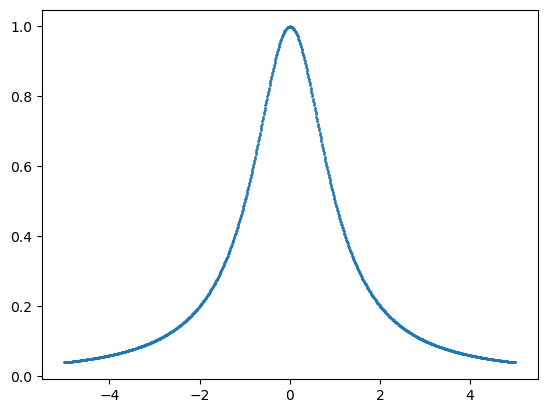

In [243]:
def create_spline_mat_clamped(n):
    """Creates the matrix for the clamped cubic spline system."""
    S = np.zeros((n, n))

    # Clamped boundary conditions
    S[0, 0] = 1
    S[n-1, n-1] = 1

    # Fill the main system
    for i in range(1, n-1):
        S[i, i-1] = 1
        S[i, i] = 4
        S[i, i+1] = 1

    S /= 12  # Normalize

    return S

def create_coefs_spline_clamped(x_data, y_data, alpha, beta):
    """Computes the cubic spline coefficients given the clamped boundary conditions."""
    n = len(x_data)
    S = create_spline_mat_clamped(n)
    Y = np.zeros(n)

    # Set boundary conditions (first and last derivatives)
    Y[0] = alpha
    Y[n-1] = beta

    # Compute second derivatives at internal points
    for i in range(1, n-1):
        f_i_i1 = (y_data[i+1] - y_data[i]) / (x_data[i+1] - x_data[i])
        f_i1_i2 = (y_data[i+1] - y_data[i-1]) / (x_data[i+1] - x_data[i-1])
        
        Y[i] = 2 * (f_i_i1 - f_i1_i2) / (x_data[i+1] - x_data[i-1])

    coefs = np.linalg.solve(S, Y)  
    return coefs

def eval_interp(x, coefs, x_data, y_data):
    """Evaluates the spline interpolation at a given x."""
    if x < np.min(x_data) or x > np.max(x_data):
        print("x is not between the points")
        return 0

    # Find the interval
    for i in range(1, len(x_data)):
        if x_data[i-1] <= x <= x_data[i]:
            break

    h = x_data[i] - x_data[i-1]

    # Compute Bi and Ci
    bi = y_data[i-1] - coefs[i-1] * h**2 / 6
    ci = y_data[i] - coefs[i] * h**2 / 6

    # Cubic spline interpolation formula
    f = (1/h) * (
        (1/6 * coefs[i-1] * (x_data[i] - x)**3) +
        (1/6 * coefs[i] * (x - x_data[i-1])**3) +
        bi * (x_data[i] - x) +
        ci * (x - x_data[i-1])
    )
    return f

def eval_interpnd(x_arr, coefs, x_data, y_data):
    """Evaluates the spline at multiple x values."""
    return [eval_interp(x, coefs, x_data, y_data) for x in x_arr]

def create_interp_spline_clamped(a, b, n, f, df):
    """Creates and evaluates a clamped cubic spline interpolator."""
    x_data = np.linspace(a, b, n)
    y_data = f(x_data)

    coefs = create_coefs_spline(x_data, y_data, df(x_data[0]), df(x_data[-1]))
    
    x_test = np.linspace(a, b, 1001)
    y_test = eval_interpnd(x_test, coefs, x_data, y_data)

    return x_test, y_test

def driver_prob1_S_clamped():
    """Runs and plots the clamped cubic spline interpolation."""
    x_test = np.linspace(-5, 5, 1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test, y_real, s=1, label="Real Function")

    ns = [5, 10, 15, 20]
    for n in ns:
        x_interp, y_interp = create_interp_spline_clamped(-5, 5, n, f_prob1, df_prob1)
        plt.plot(x_interp, y_interp, label=f"n={n}")

    plt.title("Clamped Cubic Spline Interpolation")
    plt.legend()
    plt.show()

driver_prob1_S_clamped()



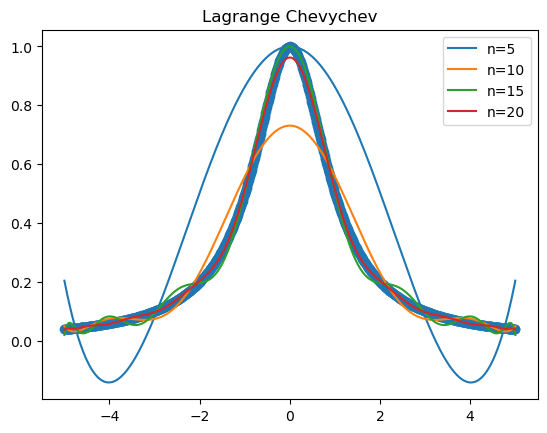

In [249]:
def create_interp_n_bary_chebychev(a,b,n,f):
    x_data = (b-a)/2*np.cos((2*np.arange(1,n+1)-1)*np.pi/(2*n)) + (a+b)/2
    y_data = f(x_data)

    x_test = np.linspace(a,b,1001)
    y_test = lagrange_bary_interp(x_test, x_data, y_data)

    return (x_test, y_test)

def driver_lagrange_chebychev():

    x_test = np.linspace(-5,5,1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test,y_real)

    ns = [5,10,15,20]
    
    for n in ns:
        (x_interp, y_interp) = create_interp_n_bary_chebychev(-5,5,n,f_prob1)
        plt.plot(x_interp, y_interp, label=f"n={n}")
    plt.title("Lagrange Chevychev")
    plt.legend()
    plt.show()

driver_lagrange_chebychev()

5
10
20


/tmp/ipykernel_107474/760613301.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(x**i*coefs[i] for i in range(len(coefs)))


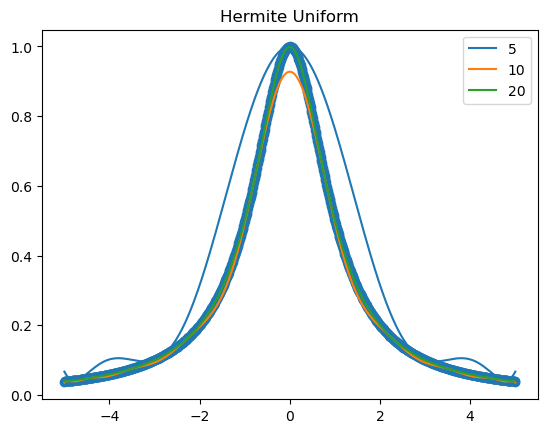

In [245]:
def create_interp_H(a,b,n,f,df):
    x_data = x_data = (b-a)/2*np.cos((2*np.arange(1,n+1)-1)*np.pi/(2*n))
    y_data = f(x_data)
    z_data = df(x_data)

    coefs = create_coefs(x_data,y_data,z_data)
    

    x_test = np.linspace(a,b,1001)
    y_test = eval_interpnd_H(x_test, coefs)

    return (x_test, y_test)



def driver_prob_H():

    x_test = np.linspace(-5,5,1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test,y_real)

    ns = [5,10,20]
    
    for n in ns:
        (x_interp, y_interp) = create_interp_H(-5,5,n,f_prob1, df_prob1)
        plt.plot(x_interp, y_interp, label = str(n))
    plt.title("Hermite Uniform")
    plt.legend()
    plt.show()
driver_prob_H()

x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the points
x is not between the

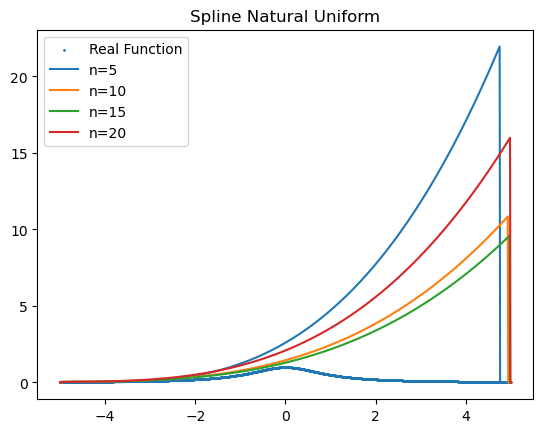

In [248]:
def create_interp_spline_chev(a, b, n, f):
    x_data = (b-a)/2*np.cos((2*np.arange(1,n+1)-1)*np.pi/(2*n))
    y_data = f(x_data)

    coefs = create_coefs_spline(x_data, y_data)
    
    x_test = np.linspace(a, b, 1001)
    y_test = eval_interpnd_S_nat(x_test, coefs, x_data, y_data)

    return x_test, y_test

def driver_prob1_S_chev():

    x_test = np.linspace(-5, 5, 1001)
    y_real = f_prob1(x_test)

    plt.scatter(x_test, y_real, s=1, label="Real Function")

    ns = [5, 10,15,20]
    for n in ns:
        x_interp, y_interp = create_interp_spline_chev(-5, 5, n, f_prob1)
        plt.plot(x_interp, y_interp, label=f"n={n}")
    plt.title("Spline Natural Uniform")
    plt.legend()
    plt.show()

driver_prob1_S_chev()
